In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric

In [3]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros(headings.shape)), axis=0)


# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros(flow.shape)), axis=0)

######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


# Extract heading during route

In [199]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [200]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_H = SpikeMonitor(P_HEADING)

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')
SPM_FLOW = SpikeMonitor(P_FLOW)

In [201]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2_source_network')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1_source_network')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1_source_network')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2_source_network')

# Synapses optimised
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=H_TL2_synapses_params, on_pre=synapses_eqs_ex)
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, 
                                params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex)
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, 
                                params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex)
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, 
                                params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in)
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, 
                                   params=F_TN2_synapses_params, on_pre=synapses_eqs_ex)

SPM_TB1 = SpikeMonitor(G_TB1)
SPM_TN2 = SpikeMonitor(G_TN2)

In [202]:
global ref_angles, heading_angles, velocities 

ref_angles = np.linspace(-np.pi+np.pi/8, np.pi+np.pi/8, N_TB1, endpoint=False)
max_velocity = 12 

heading_angles = np.zeros(T_outbound)
velocities = np.zeros((T_outbound, 2))



def extract_spike_counts(SPM, t, time_step):
    spike_trains = SPM.spike_trains()
    neurons = np.zeros(len(SPM.spike_trains()), dtype=int)
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])
    return neurons


def circular_weighted_mean(weights, angles):
    x = y = 0.
    for angle, weight in zip(angles, weights):
        x += math.cos(math.radians(angle)) * weight
        y += math.sin(math.radians(angle)) * weight
    mean = math.degrees(math.atan2(y, x))
    return mean


def make_angle(theta):
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


@network_operation(dt=time_step*ms)
def extract_heading(t):
    global ref_angles, heading_angles

    timestep = int((t/ms + 0.5) / time_step)
    
    if t < time_step*ms:
        neurons = [0,0,0,1,1,0,0,0]
        tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
        heading_angles[timestep] = make_angle(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi))
        return
    neurons = extract_spike_counts(SPM_TB1, t, time_step)    
    
    if np.sum(neurons) > 0:
        # trick to get the correct weighted average of where the heading is
        # create a list with all the angles between [-pi,pi] repeated by their count
        # so [0,2,0,0,1,0,0,1] will be [-1.963, -1.963, 0.392, 2.748] and then compute
        # circular mean between [-pi, pi]
        tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
        # -pi/8 because we center the neurons at the center of their pi/4 receptive fields
        heading_angles[timestep] = make_angle(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi) - np.pi/8)
    else:
        heading_angles[timestep] = heading_angles[timestep-1]


@network_operation(dt=time_step*ms)
def extract_velocity(t):
    global velocities, max_velocity
    
    timestep = int((t/ms + 0.5) / time_step)
    if t < time_step*ms:
        velocities[timestep] = [0,0]
        return
    neurons_responses = extract_spike_counts(SPM_TN2, t, time_step)
    neurons_responses = np.clip(neurons_responses, 0, max_velocity)
    velocities[timestep] = neurons_responses / max_velocity

In [203]:
global bee_plot, bee_x, bee_y, ref_angles

bee_x = 0
bee_y = 0

plot_angles = np.linspace(-np.pi, 0+np.pi, N_TB1, endpoint=False)

#f = plt.figure(1)
#axis([-100,100,-100,100])

#bee_plot = plot(bee_x, bee_y, 'ko') # Vehicle

@network_operation(dt=time_step*ms)
def plot_bee(t):
    global bee_plot, bee_x, bee_y, plot_angles, heading_angles, velocities 
    
    if t < time_step*ms:
        return

    timestep = int((t/ms + 0.5) / time_step)
    
    angle = heading_angles[timestep]
    x_comp = np.cos(angle)
    y_comp = np.sin(angle)
    bee_x += x_comp
    bee_y += y_comp
    #print(angle, x_comp, y_comp, bee_x, bee_y)
    #bee_plot = plot(bee_x, bee_y, 'ko')    

    #axis([-100,100,-100,100])
    #draw()
    #pause(0.01)



In [204]:
run((T_outbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 30. s
2.2038 s (7%) simulated in 10s, estimated 2m 6s remaining.
3.5494 s (11%) simulated in 20s, estimated 2m 29s remaining.
6.4217 s (21%) simulated in 30s, estimated 1m 50s remaining.
9.4958 s (31%) simulated in 40s, estimated 1m 26s remaining.
11.2601 s (37%) simulated in 50s, estimated 1m 23s remaining.
12.9196 s (43%) simulated in 1m 0s, estimated 1m 19s remaining.
15.1601 s (50%) simulated in 1m 10s, estimated 1m 9s remaining.
17.1839 s (57%) simulated in 1m 20s, estimated 1m 0s remaining.
20.5269 s (68%) simulated in 1m 30s, estimated 42s remaining.
23.8924 s (79%) simulated in 1m 40s, estimated 26s remaining.
27.0579 s (90%) simulated in 1m 50s, estimated 12s remaining.
29.9881 s (99%) simulated in 2m 0s, estimated < 1s remaining.
30. s (100%) simulated in 2m 0s


# Experiments with velocities decoding

0.0 1.0


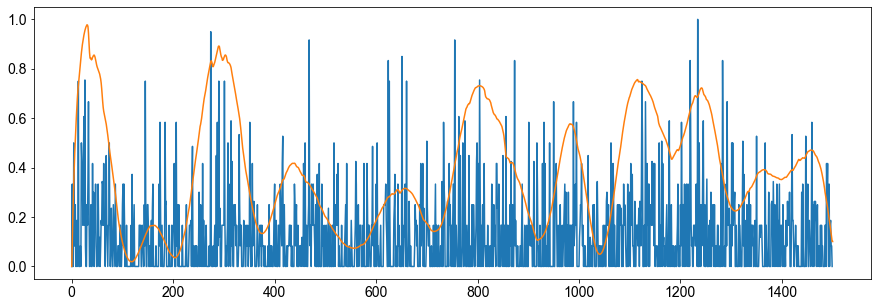

In [205]:
def get_speed(v):
    xy = np.vstack([np.array([0.0, 0.0]), np.cumsum(v, axis=0)])
    x, y = xy[:, 0], xy[:, 1]

    speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]), axis=0), 0, 1)
    return speed

print(velocities.min(), velocities.max())
plt.figure(figsize=(15,5))
plt.plot(get_speed(velocities))
plt.plot(get_speed(v), label='real speed')
plt.show()

# Experiments with heading decoding

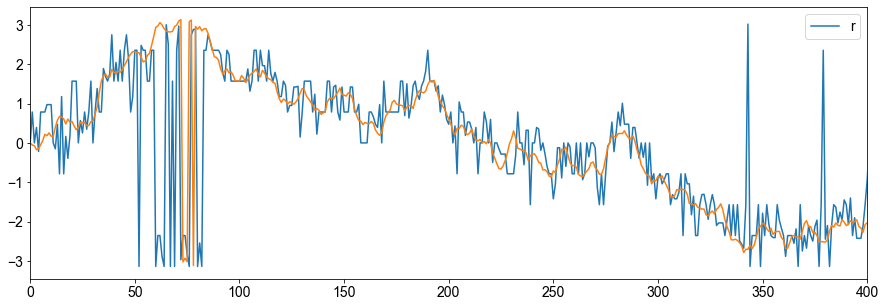

0.9165108461367437


In [208]:
plt.figure(figsize=(15,5))
#plt.plot(heading_angles-np.pi/8, label='pi/8')
plt.plot(heading_angles, label='r')
#plt.plot(fix_angle(heading_angles), label='f')
plt.plot(h)
plt.xlim([0,400])
plt.legend()
plt.show()

mse = np.mean((h[:1500] - heading_angles)**2)
print(mse)

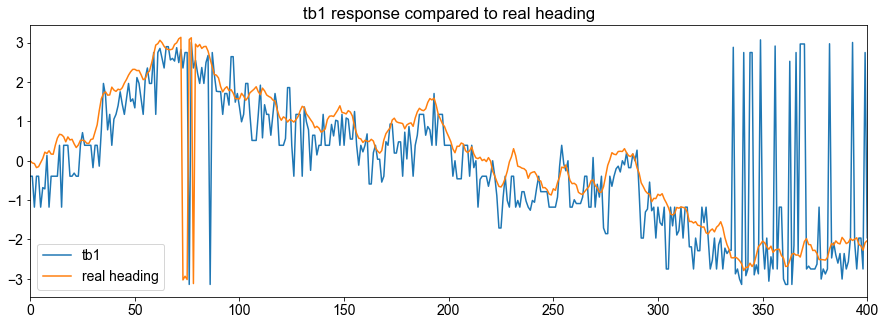

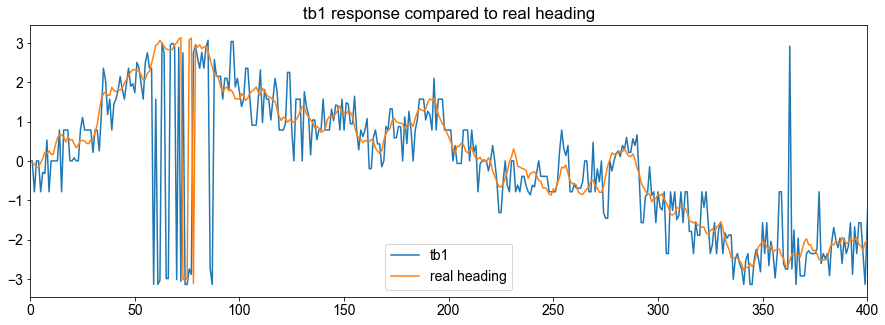

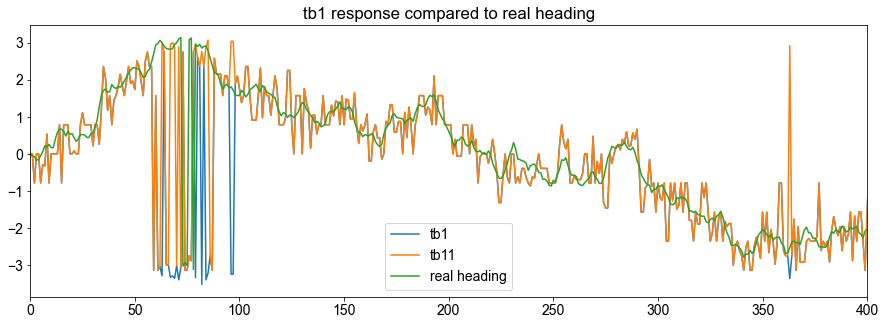

1.0681848303019776
0.8401009877437512
1.1297094566955257


In [198]:
def fix_angle(theta):
    """Return new heading after a rotation around Z axis."""
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


plt.figure(figsize=(15,5))
#plt.plot(heading_angles, label='tb1')
plt.plot(fix_angle(heading_angles-np.pi/8), label='tb1')
plt.plot(h, label='real heading')
plt.xlim([0,400])
plt.title('tb1 response compared to real heading')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
#plt.plot(heading_angles, label='tb1')
plt.plot(fix_angle(heading_angles), label='tb1')
plt.plot(h, label='real heading')
plt.xlim([0,400])
plt.title('tb1 response compared to real heading')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
#plt.plot(heading_angles, label='tb1')
plt.plot((heading_angles), label='tb1')
plt.plot(fix_angle(heading_angles), label='tb11')
plt.plot(h, label='real heading')
plt.xlim([0,400])
plt.title('tb1 response compared to real heading')
plt.legend()
plt.show()


mse = np.mean((h[:1500] - fix_angle(heading_angles-np.pi/8))**2)
print(mse)

mse = np.mean((h[:1500] - fix_angle(heading_angles))**2)
print(mse)

mse = np.mean((h[:1500] - heading_angles)**2)
print(mse)

In [182]:
neurons = [0,0,0,1,1,0,0,0]
tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons[i])]
print(scipy.stats.circmean(tmp, low=-np.pi, high=np.pi)) # range is [0,8] to represent [-pi,pi]



0.0


WARNING    /Users/ff/dev/MSc/CX_Path_Integration/cx_spiking/inputs.py:32: RuntimeWarning: invalid value encountered in greater_equal
  d = np.where(data >= 0, data, 0)
 [py.warnings]
  d = np.where(data >= 0, data, 0)



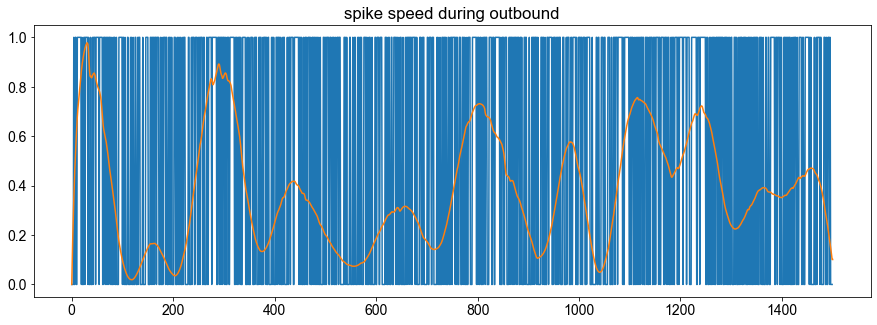

WARNING    /Users/ff/dev/MSc/CX_Path_Integration/cx_spiking/inputs.py:32: RuntimeWarning: invalid value encountered in greater_equal
  d = np.where(data >= 0, data, 0)
 [py.warnings]
  d = np.where(data >= 0, data, 0)



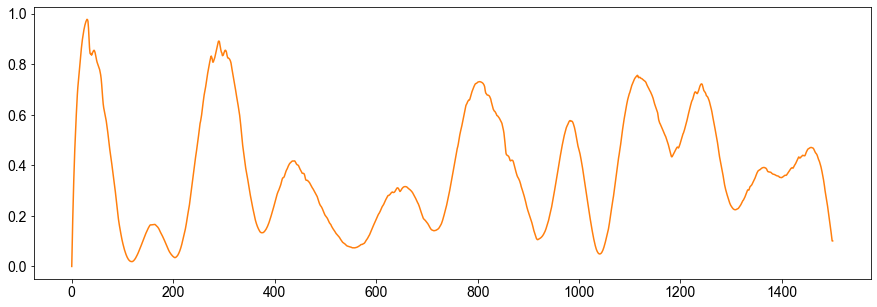

In [137]:
norm_velocities = cx_spiking.inputs.normalise_range(velocities, vmin=0, vmax=1)

def get_speed(v):
    xy = np.vstack([np.array([0.0, 0.0]), np.cumsum(v, axis=0)])
    x, y = xy[:, 0], xy[:, 1]

    speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]), axis=0), 0, 1)
    return speed


#plt.plot(velocities)
#plt.show()

speed = get_speed(norm_velocities)

plt.figure(figsize=(15,5))
plt.plot(speed, label='tn2 speed')
plt.plot(get_speed(v), label='real speed')
plt.title('spike speed during outbound')
plt.show()

#plotter.plot_route(h, v, T_outbound=1500, T_inbound=0, plot_speed=True,figsize=(5,8))
#plt.show()

norm_velocities = cx_spiking.inputs.normalise_range(np.clip(velocities,0,12), vmin=0, vmax=1)

plt.figure(figsize=(15,5))
plt.plot(get_speed(velocities))
plt.plot(get_speed(v), label='real speed')
plt.show()

In [276]:
import scipy

def circular_mean(weights, angles):
    x = y = 0.
    for angle, weight in zip(angles, weights):
        x += math.cos(math.radians(angle)) * weight
        y += math.sin(math.radians(angle)) * weight
    mean = math.degrees(math.atan2(y, x))
    return mean

def vonmises_fit(weights, sigma=0.8):
    kappa = 1./sigma**2
    vm = scipy.stats.vonmises.fit(weights, fscale=kappa)
    return vm

angles = np.linspace(-np.pi, 0+np.pi, N_TB1, endpoint=False)
angles = np.linspace(0, 2*np.pi, N_TB1, endpoint=False)


def make_angle(theta):
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


print(angles, np.rad2deg(angles))
print()

weights=[0., 0., 0., 0., 0., 4., 6., 5.]
print(weights)
circm = circular_mean(weights, angles)
#print(vonmises_fit(weights))
print(circm, np.rad2deg(circm) )
print()

weights=np.roll([0., 0., 0., 0., 0., 4., 6., 5.],4)
print(weights)
circm = circular_mean(weights, angles)
#print(vonmises_fit(weights))
print(circm, np.rad2deg(circm), make_angle(circm), np.rad2deg(make_angle(circm)) )
print()



weights = [1., 0., 0., 0., 0., 0., 2., 2.]
#weights = np.roll(weights, -4)
print(weights)
circm = circular_mean(weights, angles)
#print(vonmises_fit(weights))
print(circm, np.rad2deg(circm), make_angle(circm), np.rad2deg(make_angle(circm)) )

print()

weights = [0., 0., 0., 0., 1., 0., 0., 0.]
weights=np.roll([0., 0., 0., 0., 1., 0., 0., 0.],4)

print(weights)
circm = circular_mean(weights, angles)
#print(vonmises_fit(weights))
print(circm, np.rad2deg(circm), make_angle(circm), np.rad2deg(make_angle(circm)) )






#print(angles)

#print(circular_mean(weights, angles))

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714] [  0.  45.  90. 135. 180. 225. 270. 315.]

[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 6.0, 5.0]
4.764750155223649 273.000074328619

[0. 4. 6. 5. 0. 0. 0. 0.]
1.6231575016338562 93.00007432861898 1.6231575016338562 93.00007432861898

[0. 0. 2. 2. 1. 0. 0. 0.]
2.1991113155167477 125.99979705857199 2.199111315516747 125.99979705857196

[1. 0. 0. 0. 0. 0. 0. 0.]
0.0 0.0 0.0 0.0


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/IPython/core/history.py", line 780, in writeout_cache
    self._writeout_input_cache(conn)
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/IPython/core/history.py", line 763, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.OperationalError: database is locked


In [88]:
weights= [0,0,0,0,1,0,0,0] 
ref_angles = np.linspace(-np.pi+np.pi/8, np.pi+np.pi/8, N_TB1, endpoint=False)
#ref_angles = np.linspace(-np.pi, np.pi, N_TB1, endpoint=False)

print(ref_angles)
print(np.rad2deg(ref_angles))

tmp = []
tmp = [angle for i, angle in enumerate(ref_angles) for weight in range(weights[i])]


an = scipy.stats.circmean(tmp, low=-np.pi, high=np.pi)
print(an, math.degrees(an))

[-2.74889357 -1.96349541 -1.17809725 -0.39269908  0.39269908  1.17809725
  1.96349541  2.74889357]
[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5]
0.39269908169872414 22.5


In [96]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [97]:
motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
m2 = cx_spiking.inputs.normalise_range(motors)

h_motors = TimedArray(m2.T*Hz, dt=1.*time_step*ms)
P_MOTOR = PoissonGroup(N_MOTOR, rates='h_motors(t,i)')
SPM_MOTOR = SpikeMonitor(P_MOTOR)

In [98]:
run((T_outbound+T_inbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 60. s
31.3714 s (52%) simulated in 10s, estimated 9s remaining.
60. s (100%) simulated in 18s


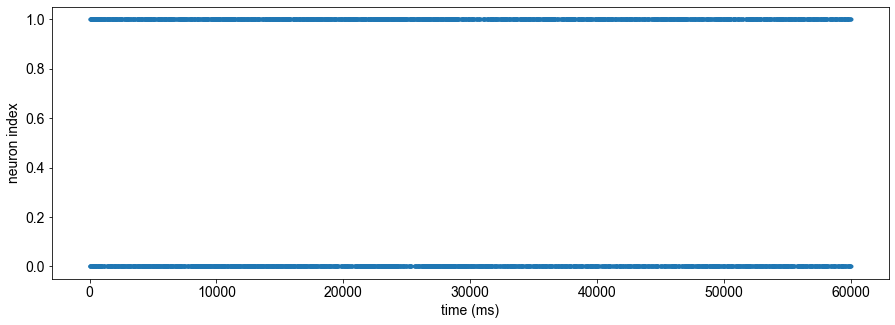

In [99]:
plt.figure(figsize=(15,5))
brian_plot(SPM_MOTOR)

In [100]:
motor_rates = cx_spiking.inputs.get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound+T_inbound, time_step)

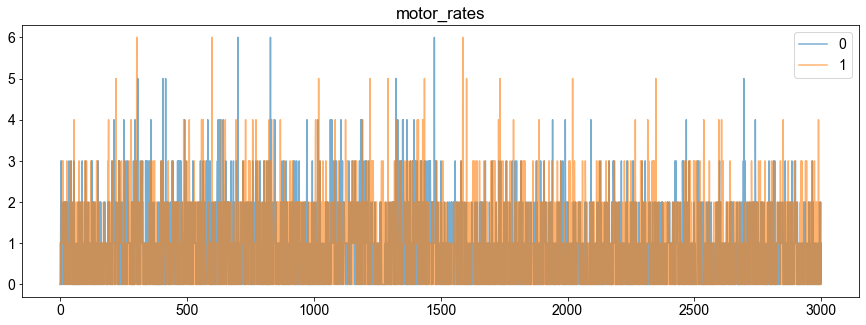

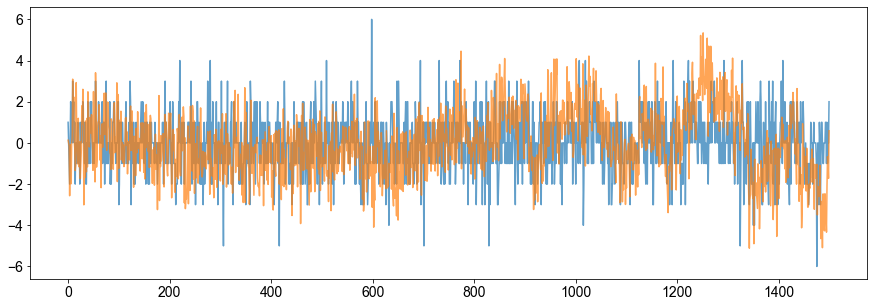

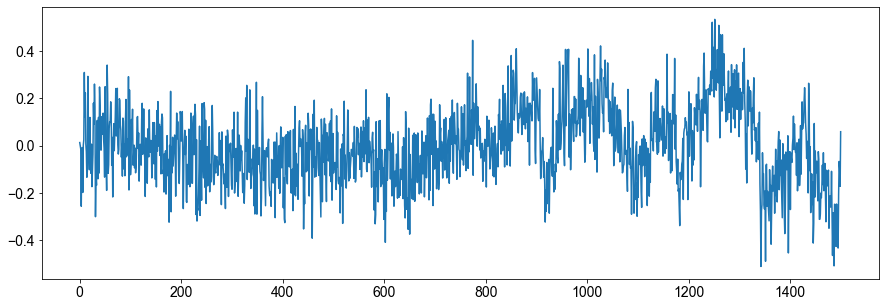

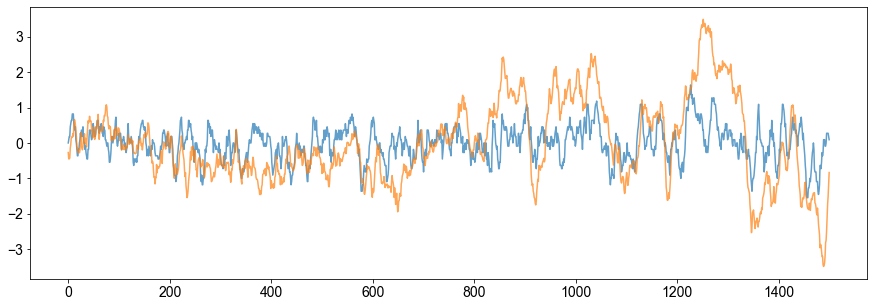

In [113]:
plt.figure(figsize=(15,5))
plt.title('motor_rates')
for idx, r in enumerate(motor_rates):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(motor_rates[1, :T_outbound] - motor_rates[0, :T_outbound], alpha=0.7, label='spiking')
plt.plot(cx_log.motor*10, alpha=0.7, label='rate')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(cx_log.motor)
plt.show()

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(15,5))
plt.plot(smooth(motor_rates[1, :T_outbound] - motor_rates[0, :T_outbound], 11), alpha=0.7, label='spiking')
plt.plot(smooth(cx_log.motor*10, 11), alpha=0.7, label='rate')
plt.show()



[5.35000e+01 6.60000e+01 6.91000e+01 ... 5.99510e+04 5.99542e+04
 5.99805e+04]


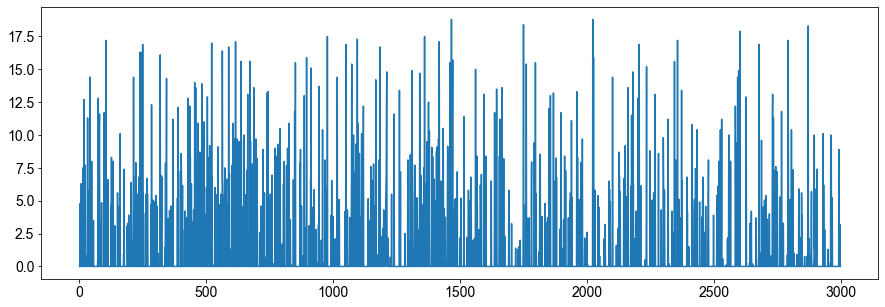

[1.77000e+01 6.93000e+01 1.11100e+02 ... 5.99403e+04 5.99555e+04
 5.99847e+04]


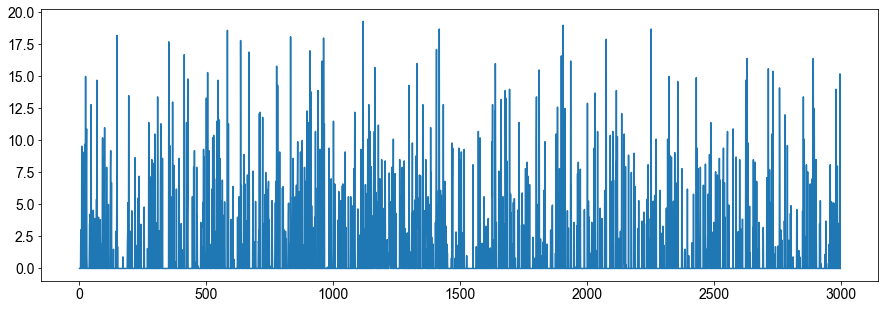

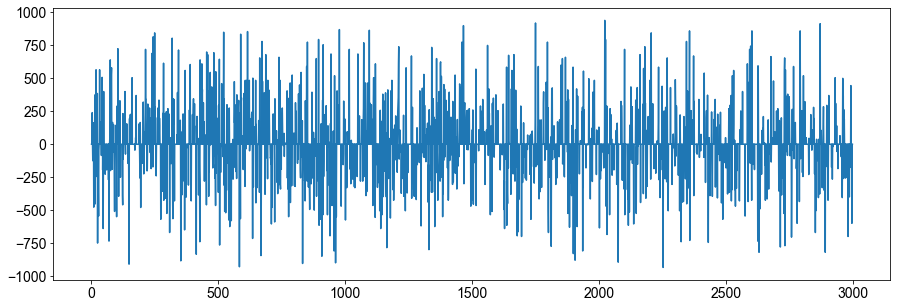

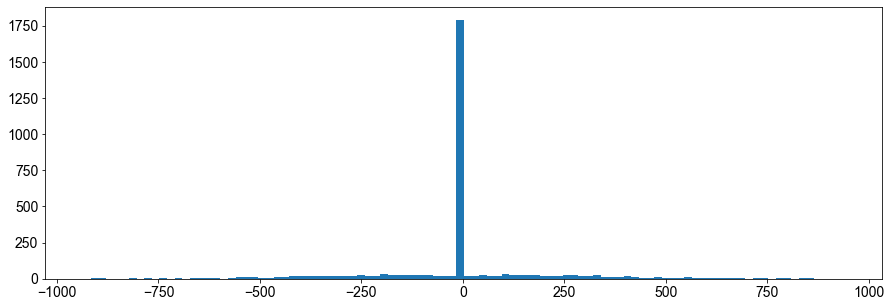

In [141]:
# compute ISI of each time_step window
spikes_t = SPM_MOTOR.t/ms
spikes_i = SPM_MOTOR.i

spikes_out = np.zeros((N_MOTOR, T_outbound+T_inbound))
bins = np.arange(0, (T_outbound+T_inbound+1)*time_step, time_step)

isi = np.zeros((N_MOTOR, T_outbound+T_inbound))
for i in range(N_MOTOR):
    spikes = spikes_t[spikes_i == i]
    print(spikes)
    for ts in range(T_outbound+T_inbound):
        idxs = np.where(np.logical_and(spikes > ts*time_step, spikes<= (ts+1)*time_step))
        spikes_to_consider = spikes[idxs]
        if len(spikes_to_consider) > 1:
            diffs = np.diff(spikes_to_consider)
            #print(ts, spikes_to_consider, diffs, np.mean(diffs))
        #spikes_count, _ = np.histogram(spikes, bins=bins)
        #spikes_out[i,:] = spikes_count
            isi[i, ts] = np.mean(diffs)
    plt.figure(figsize=(15,5))
    plt.plot(isi[i])
    plt.show()
    
plt.figure(figsize=(15,5))
plt.plot((isi[0]-isi[1])* 1000/time_step) 
plt.show()

plt.figure(figsize=(15,5))
plt.hist((isi[0]-isi[1])* 1000/time_step, bins=100)
plt.show()

# OLD STUFF

In [77]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [78]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_H = SpikeMonitor(P_HEADING)

In [79]:
run((T_outbound+T_inbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 60. s
33.4522 s (55%) simulated in 10s, estimated 8s remaining.
58.7787 s (97%) simulated in 20s, estimated < 1s remaining.
60. s (100%) simulated in 20s


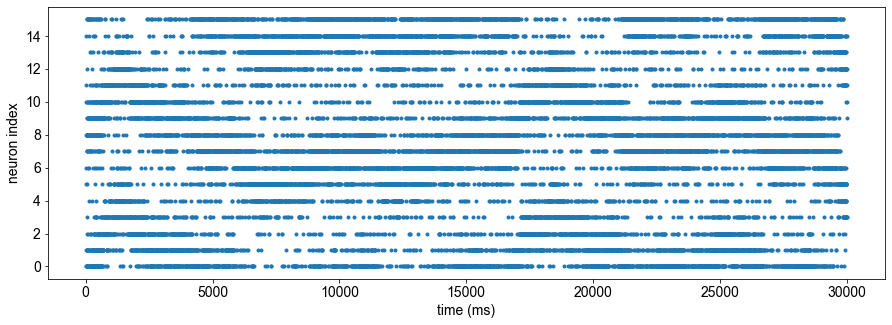

In [80]:
plt.figure(figsize=(15,5))
brian_plot(SPM_H)